In [5]:
%load_ext autoreload
%autoreload 2
import numpy as np
from MARBLE import plotting, geometry, utils, net
from DE_library import simulate_phase_portrait
import pyEDM as pyEDM
from teaspoon.parameter_selection.FNN_n import FNN_n
import matplotlib.pyplot as plt
from example_utils import plot_phase_portrait, circle, find_nn

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Simulate Lorenz system

Computing neighbours...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:12<00:00,  3.86it/s]


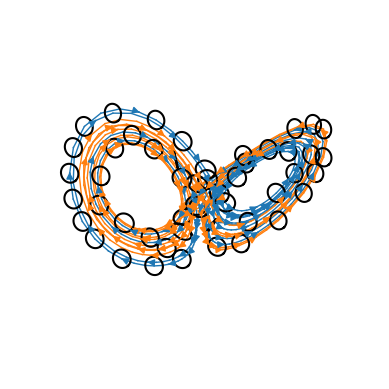

In [6]:
def simulate_system(t, X0):
    p, v = simulate_phase_portrait('lorenz', t, X0, par = {'sigma': 10.0, 'beta': 8/3.0, 'rho': 28.0, 'tau': 1.0})
    pos, vel = [], []
    for p_, v_ in zip(p,v):
        pos.append(p_)
        vel.append(v_)
        
    return pos, vel

#simulate system
X0_set = [[[-8., 7., 27.]], [[6, -6., 28.]]]
t = np.linspace(0, 10, 500)

X, V = [], []
for i, X0 in enumerate(X0_set):
    p, v = simulate_system(t, X0)
            
    X.append(np.vstack(p))
    V.append(np.vstack(v)/1e3)

ax = plot_phase_portrait(X, 
                    V, 
                    style='->', 
                    node_feature=[[i]*len(p) for i, p in enumerate(X)], 
                    lw=1,
                    ah=10,
                    spacing=5)

N=50

# ax.view_init(elev=30, azim=45)
X_emb = np.vstack(X)

ind, lamb = geometry.furthest_point_sampling(X_emb, N)

ind = np.array(list(set(ind)))
_, nn = find_nn(ind, X_emb, nn=2)

for i, nn_ in enumerate(nn):
    ax = circle(ax, 2, X_emb[[ind[i]] + list(nn_)], col='k')
    
#plt.savefig('../results/Takens_views.svg')

plt.savefig('../results/Lorenz.svg')

---- Embedding dimension: 3
---- Signal dimension: 3


Computing gauges...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.91it/s]

---- Manifold dimension: 2



Computing connections...: 100%|██████████████████████████████████████████████████████████████████████████████| 20028/20028 [00:12<00:00, 1633.23it/s]


<Axes3DSubplot:>

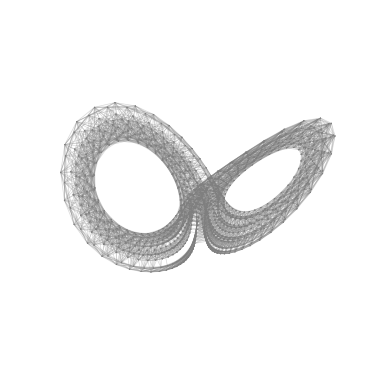

In [7]:
from torch_geometric.utils.convert import to_networkx
data = utils.construct_dataset(X, V, graph_type='cknn', k=20)
G = to_networkx(data, node_attrs=['pos'], edge_attrs=None, to_undirected=True,
        remove_self_loops=True)
plotting.graph(G,labels=None,edge_alpha=0.3, edge_width=0.5)

# Create random projections of state-space to scalar time series

In [59]:
from sklearn import random_projection
transformer = random_projection.SparseRandomProjection(n_components=1)

n_obs = 5

x = []
for i in range(n_obs):
    x_tmp = transformer.fit_transform(X[0])
    x_tmp = utils.standardise(x_tmp, norm='max')
    x.append(x_tmp[::5])
    
x_stacked = np.hstack(x)
df = utils.to_pandas(x_stacked)

# Plot trajectories

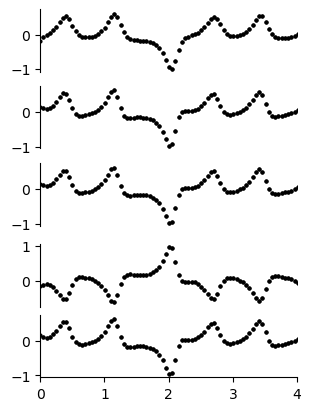

In [60]:
ax = plotting.time_series(t[::5], x, style='.', figsize=(3,4), ms=4)
plt.xlim([0,4])
plt.savefig('../results/time_series_2.svg')

# Estimate system dimension

In [ ]:
#perc_FNN, E = FNN_n(x_stacked[:,0], 1, maxDim=10, plotting=True, Rtol=15, Atol=2, threshold=10)
E = 3

# Find best multi-view embeddings

In [ ]:
#find best embedding views
columns = list(df.columns)[1:]
MVE = pyEDM.Multiview(dataFrame = df, 
                      lib = [1, 100], 
                      pred = [100, 200], 
                      E = E, 
                      D = E,
                      columns = columns, 
                      target = columns[0], 
                      showPlot = True)

views = MVE['View'].iloc[:,:E]
views = np.array(views, dtype=np.int)

#create embeddings
embedding = pyEDM.Embed(dataFrame = df, E = E, tau = -1, columns = columns)
embedding = np.array(embedding.dropna())
all_embeddings = np.stack([embedding[:,v-1] for v in views], axis=2)

# Plot embeddings

In [ ]:
n_emb = 5
N=50

fig = plt.figure(figsize=(20,10))
for j in range(n_emb):
    ax = fig.add_subplot(1, n_emb, j+1, projection='3d')
    ax.view_init(elev=30, azim=45)
    X_emb = all_embeddings[...,j]

    ind, lamb = geometry.furthest_point_sampling(X_emb, N)

    ax = plotting.trajectories(X_emb, ax=ax, style='-', lw=0.5, arrowhead=.05, axis=False)

    ind = np.array(list(set(ind)))
    _, nn = example_utils.find_nn(ind, X_emb, nn=2)

    for i, nn_ in enumerate(nn):
        ax = example_utils.circle(ax, .1, X_emb[[ind[i]] + list(nn_)])
    
#plt.savefig('../results/Takens_views.svg')

# Create dataset

In [ ]:
#first create data with the best embedding to fit the graph
best_embedding = all_embeddings[...,0]
feature = np.diff(best_embedding, axis=0) #velocity vectors
pos = best_embedding[:-1]
data = utils.construct_dataset(pos, feature, graph_type='cknn', k=10)

#now add all other embeddings
n_emb = all_embeddings.shape[2]
feature = [np.diff(all_embeddings[...,i], axis=0) for i in range(n_emb)]

#bring it to form [feature_1(x_1),...,feature_n(x_1),  feature_1(x_2),...,feature_n(x_2)]
feature = np.stack(feature, axis=2)
feature = feature.reshape(feature.shape[0], -1)

data.x = utils.np2torch(feature)
data.num_node_features = feature.shape[1]

In [ ]:
par = {'batch_size': 256, #batch size, this should be as large as possible
       'epochs': 30, #optimisation epochs
       'order': 2, #order of derivatives
       'n_lin_layers': 2,
       'hidden_channels': 16, #number of internal dimensions in MLP
       'out_channels': 4,
       'diffusion': False,
       'inner_product_features': True,
       'vector' : True
      }

model = net(data, **par)
model.run_training(data)